In [1]:
import sys
import warnings
import math
from PIL import Image
import matplotlib.pyplot as plt

import qiskit
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble, execute

from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import schedule
from qiskit.circuit.library import XGate
from qiskit.circuit.library import YGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling, ASAPSchedule
from qiskit.visualization import timeline_drawer

from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor


In [2]:
# ckt_type is 1: victim qubits on 0 and 1, and 2: victim qubits on 3 and 4
# atk_type : 1. H_delay_H, 2. H_CNOT_on_neighbour_delay_CNOT_on_neighbour_H, 3. H_p_delay_p_H
# no_of_qubits = 7 for oslo
# no_of_CX = no of CX in victim qubits

def Q_ckt (circuit_object, ckt_type, atk_type, no_of_qubits, no_of_CX):
    
    circuit_object = QuantumCircuit(no_of_qubits, no_of_qubits-2)
    qreg_q = QuantumRegister(no_of_qubits,'q')
    creg_c = ClassicalRegister(no_of_qubits-2,'c')
    if ckt_type == 1:
         circuit_object.barrier(qreg_q[0],qreg_q[1])
         for i in range(no_of_CX-1):
            circuit_object.cx(qreg_q[0],qreg_q[1])
            
         circuit_object.barrier(qreg_q[0],qreg_q[1])

         if atk_type == 1:
           
           for i in range(no_of_qubits):
              if i>1:
                 circuit_object.h(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(1800, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.h(qreg_q[i])
         
         
         elif atk_type == 2:

            for i in range(no_of_qubits):
              if i>1 and i != 3 and i !=5:
                 circuit_object.h(qreg_q[i])
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(3000, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.h(qreg_q[i])

              elif i == 3:
                      circuit_object.h(qreg_q[i])
                      circuit_object.h(qreg_q[i+2])
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])

                      circuit_object.delay(400, i, 'ns')
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])
                      circuit_object.delay(400, i+2, 'ns')
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])
                      circuit_object.delay(400, i+2, 'ns')
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])
                      circuit_object.h(qreg_q[i])
                      circuit_object.h(qreg_q[i+2])

         elif atk_type == 3:
             for i in range(no_of_qubits):
                 if i>1:
                     circuit_object.h(qreg_q[i])
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.delay(3000, i, 'ns')
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.h(qreg_q[i])

         elif atk_type == 4:
            for i in range(no_of_qubits):
                if i != 3 and i != 5:
                    circuit_object.h(qreg_q[i])
                    circuit_object.s(qreg_q[i])
                    circuit_object.delay(3000, i, 'ns')
                    circuit_object.s(qreg_q[i])
                    circuit_object.h(qreg_q[i])
                    
         cnt = 0
         circuit_object.barrier()
         for i in range(no_of_qubits):
             
             if i>1:
                 
                 circuit_object.measure(qreg_q[i], creg_c[cnt])
                 cnt += 1
    

    elif ckt_type == 2:
      #   circuit_object.barrier(qreg_q[0],qreg_q[1])
        for i in range(no_of_CX-1):
            circuit_object.cx(qreg_q[3],qreg_q[5])
            
      #   circuit_object.barrier(qreg_q[0],qreg_q[1])

        if atk_type == 1:
           
           for i in range(no_of_qubits):
              if i != 3 and i != 5:
                 circuit_object.h(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(1800, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.h(qreg_q[i])

        elif atk_type == 2:
            for i in range(no_of_qubits):
              if i != 3 and i !=5:
                 if i == 1:
                  circuit_object.h(qreg_q[i])
                  circuit_object.h(qreg_q[i-1])
                  circuit_object.h(qreg_q[i+1])
                  circuit_object.cx(qreg_q[i],qreg_q[i+1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i-1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i+1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i-1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i+1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i-1])
                  circuit_object.delay(600, i+1, 'ns')
                  circuit_object.h(qreg_q[i])
                  circuit_object.h(qreg_q[i-1])
                  circuit_object.h(qreg_q[i+1])


                 elif i!= 0 and i!= 2:
                  circuit_object.h(qreg_q[i])
                  
                  circuit_object.delay(3000, i, 'ns')
                  
                  circuit_object.h(qreg_q[i])


        elif atk_type == 3:
            for i in range(no_of_qubits):
                 if i != 3 and i != 5:
                     circuit_object.h(qreg_q[i])
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.delay(3000, i, 'ns')
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.h(qreg_q[i])

        elif atk_type == 4:
            for i in range(no_of_qubits):
                if i != 3 and i != 5:
                    circuit_object.h(qreg_q[i])
                    circuit_object.s(qreg_q[i])
                    circuit_object.delay(3000, i, 'ns')
                    circuit_object.s(qreg_q[i])
                    circuit_object.h(qreg_q[i])

         
        cnt = 0
          
        circuit_object.barrier()
        for i in range(no_of_qubits):
            if i!= 3 and i !=5:
                 
                 circuit_object.measure(qreg_q[i], creg_c[cnt])
                 cnt += 1


         

    return circuit_object
     
        



In [3]:
# ckt_type is 1: victim qubits on 0 and 1, and 2: victim qubits on 3 and 4
# atk_type : 1. H_delay_H, 2. H_CNOT_on_neighbour_delay_CNOT_on_neighbour_H, 3. H_p_delay_p_H
# no_of_qubits = 7 for oslo
# no_of_CX = no of CX in victim qubits

def Q_victim (circuit_object, ckt_type, atk_type, no_of_qubits, no_of_CX):
    
    circuit_object = QuantumCircuit(no_of_qubits, no_of_qubits-2)
    qreg_q = QuantumRegister(no_of_qubits,'q')
    creg_c = ClassicalRegister(no_of_qubits-2,'c')
    if ckt_type == 1:
         circuit_object.barrier(qreg_q[0],qreg_q[1])
         for i in range(no_of_CX-1):
            circuit_object.cx(qreg_q[0],qreg_q[1])
            
         circuit_object.barrier(qreg_q[0],qreg_q[1])

         if atk_type == 1:
           
           for i in range(no_of_qubits):
              if i>1:
                 circuit_object.h(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(1800, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.h(qreg_q[i])
         
         
         elif atk_type == 2:

            for i in range(no_of_qubits):
              if i>1 and i != 3 and i !=5:
                 circuit_object.h(qreg_q[i])
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(3000, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.h(qreg_q[i])

              elif i == 3:
                      circuit_object.h(qreg_q[i])
                      circuit_object.h(qreg_q[i+2])
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])

                      circuit_object.delay(400, i, 'ns')
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])
                      circuit_object.delay(400, i+2, 'ns')
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])
                      circuit_object.delay(400, i+2, 'ns')
                      circuit_object.cx(qreg_q[i],qreg_q[i+2])
                      circuit_object.h(qreg_q[i])
                      circuit_object.h(qreg_q[i+2])

         elif atk_type == 3:
             for i in range(no_of_qubits):
                 if i>1:
                     circuit_object.h(qreg_q[i])
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.delay(3000, i, 'ns')
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.h(qreg_q[i])

         elif atk_type == 4:
            for i in range(no_of_qubits):
                if i != 3 and i != 5:
                    circuit_object.h(qreg_q[i])
                    circuit_object.s(qreg_q[i])
                    circuit_object.delay(3000, i, 'ns')
                    circuit_object.s(qreg_q[i])
                    circuit_object.h(qreg_q[i])
                    
         cnt = 0
         circuit_object.barrier()
         for i in range(no_of_qubits):
             
             if i<2:
                 
                 circuit_object.measure(qreg_q[i], creg_c[cnt])
                 cnt += 1
    

    elif ckt_type == 2:
      #   circuit_object.barrier(qreg_q[0],qreg_q[1])
        for i in range(no_of_CX-1):
            circuit_object.cx(qreg_q[3],qreg_q[5])
            
      #   circuit_object.barrier(qreg_q[0],qreg_q[1])

        if atk_type == 1:
           
           for i in range(no_of_qubits):
              if i != 3 and i != 5:
                 circuit_object.h(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(1800, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.x(qreg_q[i])
                 circuit_object.delay(300, i, 'ns')
                 circuit_object.h(qreg_q[i])

        elif atk_type == 2:
            for i in range(no_of_qubits):
              if i != 3 and i !=5:
                 if i == 1:
                  circuit_object.h(qreg_q[i])
                  circuit_object.h(qreg_q[i-1])
                  circuit_object.h(qreg_q[i+1])
                  circuit_object.cx(qreg_q[i],qreg_q[i+1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i-1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i+1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i-1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i+1])
                  circuit_object.delay(300, i, 'ns')
                  circuit_object.cx(qreg_q[i],qreg_q[i-1])
                  circuit_object.delay(600, i+1, 'ns')
                  circuit_object.h(qreg_q[i])
                  circuit_object.h(qreg_q[i-1])
                  circuit_object.h(qreg_q[i+1])


                 elif i!= 0 and i!= 2:
                  circuit_object.h(qreg_q[i])
                  
                  circuit_object.delay(3000, i, 'ns')
                  
                  circuit_object.h(qreg_q[i])


        elif atk_type == 3:
            for i in range(no_of_qubits):
                 if i != 3 and i != 5:
                     circuit_object.h(qreg_q[i])
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.delay(3000, i, 'ns')
                     circuit_object.p(math.pi/4,qreg_q[i])
                     circuit_object.h(qreg_q[i])

        elif atk_type == 4:
            for i in range(no_of_qubits):
                if i != 3 and i != 5:
                    circuit_object.h(qreg_q[i])
                    circuit_object.s(qreg_q[i])
                    circuit_object.delay(3000, i, 'ns')
                    circuit_object.s(qreg_q[i])
                    circuit_object.h(qreg_q[i])

         
        cnt = 0
          
        circuit_object.barrier()
        for i in range(no_of_qubits):
            if i== 3 or i ==5:
                 
                 circuit_object.measure(qreg_q[i], creg_c[cnt])
                 cnt += 1


         

    return circuit_object
     
        



In [7]:
#creating Quantum Circuits to be run. Vary Q_ckt parameters to change results. Obtain 10 results for each type of circuit to analyse better.

i = 10
qc_list = []
qc_sim_1 = QuantumCircuit
qc_sim_2 = QuantumCircuit
qc_sim_3 = QuantumCircuit
qc_sim_4 = QuantumCircuit
qc_vic_1 = QuantumCircuit
qc_vic_2 = QuantumCircuit
qc_vic_3 = QuantumCircuit
qc_vic_4 = QuantumCircuit

for j in range(i):
    if j <10:
        
        qc_sim_1 = Q_ckt(qc_sim_1, 2, 1, 7, j)

    # elif j>9:
    #     qc_sim_2 = Q_ckt(qc_sim_2, 1, 1)
    if j != 0:
        qc_list.append(qc_sim_1)
    # qc_list.append

j = 0
for j in range(i):
    if j <10:
        
        qc_sim_2 = Q_ckt(qc_sim_2, 2, 2, 7, j)

    # elif j>9:
    #     qc_sim_2 = Q_ckt(qc_sim_2, 1, 1)
    if j != 0:
        qc_list.append(qc_sim_2)

j = 0

for j in range(i):
    if j <10:
        
        qc_sim_3 = Q_ckt(qc_sim_3, 2, 3, 7, j)

    # elif j>9:
    #     qc_sim_2 = Q_ckt(qc_sim_2, 1, 1)
    if j != 0:
        qc_list.append(qc_sim_3)

j = 0

for j in range(i):
    if j<10:
        qc_sim_4 = Q_ckt(qc_sim_4, 2, 4, 7, j)

    if j != 0:
        qc_list.append(qc_sim_4)

j = 0

for j in range(i):
    if j<10:
        qc_vic_1 = Q_victim(qc_vic_1, 2, 4, 7, j)

    if j != 0:
        qc_list.append(qc_vic_1)

j = 0

for j in range(i):
    if j<10:
        qc_vic_2 = Q_victim(qc_vic_2, 2, 4, 7, j)

    if j != 0:
        qc_list.append(qc_vic_2)

j = 0

for j in range(i):
    if j<10:
        qc_vic_3 = Q_victim(qc_vic_3, 2, 4, 7, j)

    if j != 0:
        qc_list.append(qc_vic_3)

j = 0

for j in range(i):
    if j<10:
        qc_vic_4 = Q_victim(qc_vic_4, 2, 4, 7, j)

    if j != 0:
        qc_list.append(qc_vic_4)


# print(qc_list[56])   


     ┌───┐┌───┐┌─────────────────┐       ┌───┐              ┌───┐            »
q_0: ┤ H ├┤ S ├┤ Delay(3000[ns]) ├───────┤ S ├──────────────┤ H ├────────────»
     ├───┤├───┤├─────────────────┤       ├───┤              ├───┤            »
q_1: ┤ H ├┤ S ├┤ Delay(3000[ns]) ├───────┤ S ├──────────────┤ H ├────────────»
     ├───┤├───┤├─────────────────┤       ├───┤              ├───┤            »
q_2: ┤ H ├┤ S ├┤ Delay(3000[ns]) ├───────┤ S ├──────────────┤ H ├────────────»
     └───┘└───┘└─────────────────┘       └───┘              └───┘            »
q_3: ──■────────────────■────────────────────────────────────────────────────»
       │  ┌───┐         │                ┌───┐       ┌─────────────────┐┌───┐»
q_4: ──┼──┤ H ├─────────┼────────────────┤ S ├───────┤ Delay(3000[ns]) ├┤ S ├»
     ┌─┴─┐└───┘       ┌─┴─┐              └───┘       └─────────────────┘└───┘»
q_5: ┤ X ├────────────┤ X ├──────────────────────────────────────────────────»
     └───┘┌───┐       ├───┤       ┌─────────────────

In [ ]:
#Run on quantum backend
IBMQ.save_account('7e3bfaa3586a442a2b09204ec750740aa66d2ef687b92b66b40e7205277107a9ad37fa8a75c9d2698dd84f2f61d0efde579d94058bd90e7fb86aac597fc93ff9')
IBMQ.load_account()
# 79b55ac08e0de607cfadd078858753a89f3b8f153250a98c757fc4f958346850d48e59a481f07e461d8adeab9e0047a4ae6d7bbff54cf52702c827fb7ace6eee
# 7e3bfaa3586a442a2b09204ec750740aa66d2ef687b92b66b40e7205277107a9ad37fa8a75c9d2698dd84f2f61d0efde579d94058bd90e7fb86aac597fc93ff9
# provider = IBMQ.get_provider(hub='ibm-q')
# provider.backends()
# backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
#                                    x.configuration().n_qubits >= 2 and
#                                    not x.configuration().simulator and x.status().operational==True))
# print("least busy backend: ", backend)


provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend("ibm_oslo")

configrc.store_credentials:WARNING:2023-03-11 14:51:24,636: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-03-11 14:51:24,958: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# durations = InstructionDurations(
#     [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
#      ("cx", [1, 2], 200), ("cx", [2,1], 200), ("cx", [2,1], 200)("cx", [2, 3], 300),
#      ("x", None, 50),("y", None, 50), ("measure", None, 1000)]
durations = InstructionDurations(
    [("rz", None, 50), ("cx", None, 300), ("reset", None, 10),
     ("x", None, 50),("sx", None, 50),("y", None, 50),("id", None, 2000), ("measure", None, 500)]
)

In [ ]:
# balanced DD sequence on all qubits
# dd_sequence = [XGate(), XGate(),XGate(),XGate()]
# pm = PassManager([ASAPSchedule(durations),
#                   DynamicalDecoupling(durations, dd_sequence)])
pm = PassManager([ALAPSchedule(durations)])
# circ_dd = pm.run(qc_sim)
# timeline_drawer(circ_dd)

In [ ]:
# Run Experiment on local simulator


aer_sim = Aer.get_backend('aer_simulator')
shots = 8024

# qobj = assemble(bv_circuit)
# results = aer_sim.run(qobj).result()

sim_stabilizer = Aer.get_backend('aer_simulator')
job_stabilizer = sim_stabilizer.run(qc_list, shots=shots)
counts_stabilizer = job_stabilizer.result().get_counts()

# answer = results.get_counts()
# print(counts_stabilizer)
# plot_histogram(counts_stabilizer)


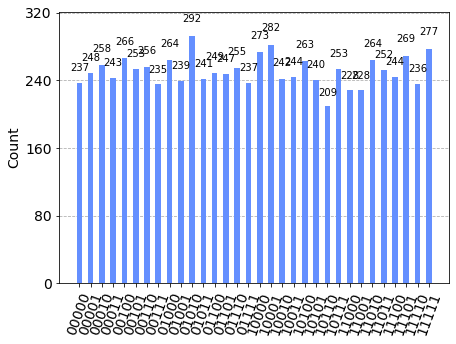

In [ ]:
plot_histogram(job_stabilizer.result().get_counts(qc_list[19]))

In [ ]:
l = 27

path = "C:/Users/Navnil Choudhury/Desktop/Quantum_Experiments/Experiments/Corr_expt_set_1_rep_1/"
for j in range(l):
    if j>17:
        plot_histogram(job_stabilizer.result().get_counts(qc_list[j]), filename = path + 'output_sim'+str(j)+'.png')

In [ ]:
transpiled_ckt_list = transpile(qc_list, provider.get_backend("ibm_oslo"), optimization_level= 0, scheduling_method='asap')
circ_s = pm.run(transpiled_ckt_list)

qobj = assemble(transpiled_ckt_list, device)

device = provider.get_backend("ibm_oslo")
job = device.run(transpiled_ckt_list, shots=8000)
job.result().get_counts()

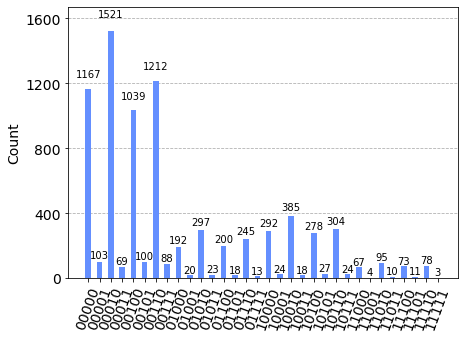

In [ ]:
#results

plot_histogram(job.result().get_counts(qc_list[11]))

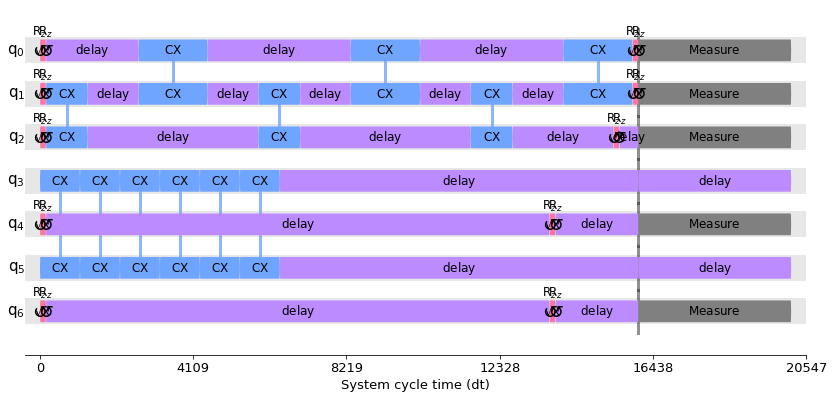

In [ ]:
timeline_drawer(transpiled_ckt_list[15], show_delays = 'True')

In [ ]:
# check transpiled circuit timing diagram
# timeline_drawer(transpiled_ckt_list[1], show_delays = 'True')

#saving timing diagrams
i = len(qc_list)
path = "C:/Users/Navnil Choudhury/Desktop/Quantum_Experiments/Experiments/Corr_expt_set_1_rep_1/"
for k in range(i):
    timeline_drawer(transpiled_ckt_list[k] ,show_delays='True', filename= path+'timing_diagram'+ str(k) +'.png')


In [ ]:
#saving results
result = job.result()
path = 'C:/Users/Navnil Choudhury/Desktop/Quantum_Experiments/Experiments/Corr_expt_set_1_rep_1/'
for j in range(len(qc_list)):
    answer = job.result().get_counts(qc_list[j])
    plot_histogram(answer, filename = path+'output'+str(j)+'.png')